In [ ]:
!nvidia-smi

Tue Dec 30 16:28:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Environment
Snake game environment

##Parameter
- board_size : The size of a square board. The board has the shape (board_size, board_size).

- n_target : The number of targets placed on a board.
- n_channel : The number of channels of the observation. The observation has the shape (n_channel, board_size, board_size).
##Observation
Observation Space : Box(-1.0, 1.0, (n_channel, 8), float32)


##Channel
- 1 : Like the rendering format, all information is expressed in one channel.
- 2 : The snake and item channels are divided.
  - 0 : snake
  - 1 : item
- 4 : Channels are divided in the following order.
  - 0 : snake's head
  - 1 : snake's body
  - 2 : snake's tail
  - 3 : item
##How to represent each element. (Old version)
- 0 : empty
- 1 ~ board_size ** 2 : snake body
  - 1 : head
  - largest number : tail
- board_size ** 2 + 1 : target

##How to represent each element. (New version)
[head_x, head_y, food_dx, food_dy, dist_up, dist_down, dist_left, dist_right]

head_x, head_y: snake's head coordinates (normalized)

food_dx, food_dy: distance between food and head along x and y axis

dist_up, dist_down, dist_left, dist_right: distance to danger (both snake body and grid borders) in all the directions
##Action
Action Space : Discrete(4)

- 0 : down
- 1 : right
- 2 : up
- 3 : left
##Invalid Action
When the Agent takes an Invalid Action, the Agent continues in the direction it was previously going.


#Step 1 - Imports

In [ ]:
import gym_snakegame
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from collections import deque

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


#Step 2: Replay Buffer & Neural Network

Replay Buffer: Stores experiences $(S, A, R, S', Done)$
 and samples them randomly to break correlations between consecutive frames.

DQN: Maps the current state (100 inputs for every cell in input space) to Q-values for every possible action (4 outputs).

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (torch.tensor(states, dtype=torch.float32).to(DEVICE),
                torch.tensor(actions, dtype=torch.int64).to(DEVICE),
                torch.tensor(rewards, dtype=torch.float32).to(DEVICE),
                torch.tensor(next_states, dtype=torch.float32).to(DEVICE),
                torch.tensor(dones, dtype=torch.float32).to(DEVICE))

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, x):
        return self.net(x)

def select_action(model, state, epsilon, act_dim):
    # Exploration: random action
    if random.random() < epsilon:
        return random.randrange(act_dim)
    # Exploitation: best action according to the network
    with torch.no_grad():
        # Inference: NN estimates action-value function
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        return int(torch.argmax(model(state)).item())

#Step 3: The Dual-Mode Training Function

This function contains the core logic. It accepts a double_dqn boolean flag.

Standard DQN: The Target Net finds the max Q-value directly. It is optimistic.

Double DQN: The Policy Net chooses the best action (argmax), and the Target Net calculates the value of that specific action. This separation prevents the "optimism" from spiraling out of control.

In [ ]:
def run_snake_game_experiment(exp_name, double_dqn=True, total_episodes=400):
    env = gym.make(
        "gym_snakegame/SnakeGame-v0", board_size=10, n_channel=1, n_target=1, render_mode=None # 'human' to visualize during training
    )
    # Space Dim. 1x10x10
    obs_dim = np.prod(env.observation_space.shape)
    action_dim = env.action_space.n

    # Hyperparameters
    lr = 1e-4
    gamma = 0.95
    batch_size = 64
    target_update_freq = 1000
    buffer_capacity = 20000
    min_buffer_size = 2000
    epsilon_decay = 200000 # Decay based on steps, not episodes
    # diminuendo epsilon_decay, l'agente esplora più a lungo

    # Initialize Networks
    policy_net = DQN(obs_dim, action_dim).to(DEVICE)
    target_net = DQN(obs_dim, action_dim).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(buffer_capacity)

    epsilon_start = 1.0
    epsilon_final = 0.01
    steps_done = 0
    rewards_history = []
    q_value_history = [] # To track Maximization Bias

    print(f"--- Starting: {exp_name} | Double: {double_dqn} ---")
    episode_max_reward = -2
    episode_min_reward = 100

    for episode in range(total_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_q_vals = []
        loss = 0

        while True:
            # Epsilon Decay (Exponential)
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)

            action = select_action(policy_net, state, epsilon, action_dim)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            steps_done += 1

            if len(replay_buffer) >= min_buffer_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    if double_dqn:
                        # --- DOUBLE DQN LOGIC ---
                        # 1. Action Selection: Policy Net decides "which" action is best
                        # Takes higher value from output layer of actions
                        # (batch_size, output_values) => returns best action for each element in batch
                        best_actions = policy_net(next_states).argmax(1)
                        # 2. Action Evaluation: Target Net calculates the value of THAT action
                        next_q = target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    else:
                        # --- STANDARD DQN LOGIC ---
                        # Target Net selects AND evaluates (Max operator). This causes bias.
                        # output è una tupla: ([values], [indices]) => prende i valori
                        next_q = target_net(next_states).max(1)[0]

                    target = rewards + (1 - dones) * gamma * next_q

                # Stime Q(s,a) per ogni azione [batch, num_actios]
                q_values = policy_net(states)
                # seleziona il valore Q corrispondente all’azione eseguita per ogni stato del batch
                # array dim. [batch, 1]
                current = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                # Save average Q-value for analysis
                episode_q_vals.append(current.mean().item())

                loss = nn.SmoothL1Loss()(current, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1.0)
                optimizer.step()

            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        rewards_history.append(episode_reward)
        q_value_history.append(np.mean(episode_q_vals) if episode_q_vals else 0)
        if episode_reward > episode_max_reward:
            episode_max_reward = episode_reward
        elif episode_reward < episode_min_reward:
            episode_min_reward = episode_reward

        if episode % 50 == 0:
            print(f"Ep {episode}: Reward {episode_reward:.2f}, Min: {episode_min_reward:.2f}, Max: {episode_max_reward:.2f} | Avg Q: {q_value_history[-1]:.2f} | Eps: {epsilon:.2f} | Loss: {loss:.4f}")
            episode_max_reward = -2
            episode_min_reward = 100

    # --- SALVATAGGIO DEL MODELLO ---
    save_path = f"trained_model5.pth"
    torch.save(policy_net.state_dict(), save_path)
    print(f"Modello salvato con successo in: {save_path}")

    env.close()
    return rewards_history, q_value_history

#Step 4: Running the Comparison

We run the training loop twice to collect data for comparison.

In [ ]:
results = {}
N_EPISODES = 22000

# 1. Train Standard DQN
# print("Collecting data for Standard DQN...")
# res_dqn = run_snake_game_experiment('DQN', double_dqn=False, total_episodes=N_EPISODES)
# results['Standard DQN'] = res_dqn

# 2. Train Double DQN
print("\nCollecting data for Double DQN...")
res_ddqn = run_snake_game_experiment('Double_DQN', double_dqn=True, total_episodes=N_EPISODES)
results['Double DQN'] = res_ddqn


--- Starting: Double_DQN | Double: True ---
Ep 0: Reward -1.00, Min: 100.00, Max: -1.00 | Avg Q: 0.00 | Eps: 1.00 | Loss: 0.0000


/usr/local/lib/python3.12/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.12/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Ep 50: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: 0.00 | Eps: 1.00 | Loss: 0.0000
Ep 100: Reward 0.00, Min: -1.00, Max: 1.00 | Avg Q: 0.00 | Eps: 0.99 | Loss: 0.0000
Ep 150: Reward -1.00, Min: -1.00, Max: 1.00 | Avg Q: -0.04 | Eps: 0.99 | Loss: 0.0252
Ep 200: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: -0.05 | Eps: 0.99 | Loss: 0.0208
Ep 250: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: -0.03 | Eps: 0.98 | Loss: 0.0086
Ep 300: Reward -1.00, Min: -1.00, Max: 1.00 | Avg Q: -0.03 | Eps: 0.98 | Loss: 0.0101
Ep 350: Reward 1.00, Min: -1.00, Max: 1.00 | Avg Q: -0.04 | Eps: 0.98 | Loss: 0.0041
Ep 400: Reward -1.00, Min: -1.00, Max: 1.00 | Avg Q: -0.04 | Eps: 0.97 | Loss: 0.0054
Ep 450: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: 0.03 | Eps: 0.97 | Loss: 0.0064
Ep 500: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: 0.05 | Eps: 0.96 | Loss: 0.0046
Ep 550: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: 0.11 | Eps: 0.96 | Loss: 0.0124
Ep 600: Reward -1.00, Min: -1.00, Max: 0.00 | Avg Q: 0.16 | Ep

# Step 5: Plotting results

We show the plots of the results obtained after training the agent.

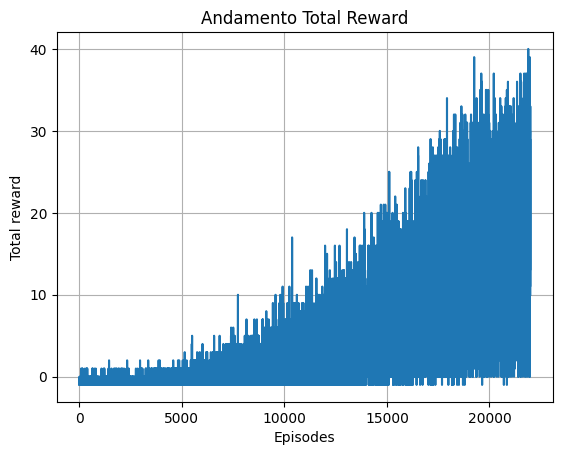

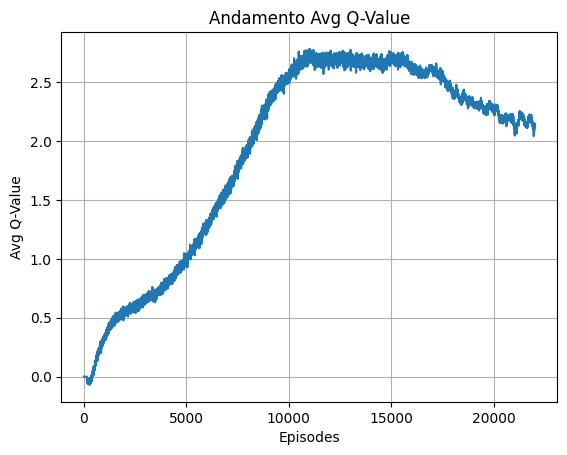

In [ ]:
def plot_funzioni(lista1, lista2):
    """
    Mostra due grafici distinti per l'andamento di due liste di valori.

    Parametri:
    - lista1: lista di valori numerici (es. Total reward)
    - lista2: lista di valori numerici (es. Avg Q-Value)
    """
    if len(lista1) != len(lista2):
        raise ValueError("Le due liste devono avere la stessa lunghezza")

    x = range(len(lista1))

    # Grafico 1: lista1
    plt.figure()
    plt.plot(x, lista1)
    plt.xlabel("Episodes")
    plt.ylabel("Total reward")
    plt.title("Andamento Total Reward")
    plt.grid(True)
    plt.show()

    # Grafico 2: lista2
    plt.figure()
    plt.plot(x, lista2)
    plt.xlabel("Episodes")
    plt.ylabel("Avg Q-Value")
    plt.title("Andamento Avg Q-Value")
    plt.grid(True)
    plt.show()

plot_funzioni(results['Double DQN'][0],results['Double DQN'][1])

#Step 6: Visualizing game performance

We try to run the game several number of times and then we compute the statistical data

In [ ]:
def watch_agent_play(model_path, board_size=10, num_episodes=100):
    """
    Carica un modello e visualizza un numero specificato di partite.

    Args:
        model_path (str): Percorso del file .pth
        board_size (int): Dimensione della mappa
        num_episodes (int): Numero di partite da giocare
    """

    # 1. Configura l'ambiente
    env = gym.make(
        "gym_snakegame/SnakeGame-v0",
        board_size=board_size,
        n_channel=1,
        n_target=1,
        render_mode=None
    )

    # 2. Ricalcola le dimensioni
    obs_dim = np.prod(env.observation_space.shape)
    action_dim = env.action_space.n

    # 3. Inizializza la rete e carica i pesi
    model = DQN(obs_dim, action_dim).to(DEVICE)

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    except FileNotFoundError:
        print(f"Errore: Il file '{model_path}' non è stato trovato.")
        return

    model.eval()
    print(f"Modello caricato da: {model_path}")
    print(f"Avvio di {num_episodes} partite di test...")

    all_rewards = []

    # --- CICLO DEGLI EPISODI ---
    for i_ep in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        print(f"\n--- Inizio Partita {i_ep + 1}/{num_episodes} ---")

        while not done:
            # Prepara lo stato
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                q_values = model(state_tensor)
                action = q_values.argmax(dim=1).item()

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # Opzionale: rallenta leggermente per rendere l'azione più visibile all'occhio umano
            # time.sleep(0.05)

        # Fine dell'episodio corrente
        print(f"Partita {i_ep + 1} terminata! Reward totale: {total_reward}")
        all_rewards.append(total_reward)

        # Pausa breve tra una partita e l'altra
        #time.sleep(1.0)

    env.close()

    # Statistiche finali
    mean_reward = np.mean(all_rewards)
    print("\n==================================")
    print(f"Sessione conclusa.")
    print(f"Partite giocate: {num_episodes}")
    print(f"Reward Medio: {mean_reward:.2f}")
    print(f"Miglior Partita: {np.max(all_rewards)}")
    print("==================================")

# --- ESECUZIONE ---
# Esempio: Visualizza 3 partite
watch_agent_play("trained_model5.pth", num_episodes=100)

Modello caricato da: trained_model5.pth
Avvio di 100 partite di test...

--- Inizio Partita 1/100 ---
Partita 1 terminata! Reward totale: 29

--- Inizio Partita 2/100 ---
Partita 2 terminata! Reward totale: 19

--- Inizio Partita 3/100 ---
Partita 3 terminata! Reward totale: 22

--- Inizio Partita 4/100 ---
Partita 4 terminata! Reward totale: 22

--- Inizio Partita 5/100 ---
Partita 5 terminata! Reward totale: 19

--- Inizio Partita 6/100 ---
Partita 6 terminata! Reward totale: 27

--- Inizio Partita 7/100 ---
Partita 7 terminata! Reward totale: 11

--- Inizio Partita 8/100 ---
Partita 8 terminata! Reward totale: 29

--- Inizio Partita 9/100 ---
Partita 9 terminata! Reward totale: 16

--- Inizio Partita 10/100 ---
Partita 10 terminata! Reward totale: 23

--- Inizio Partita 11/100 ---
Partita 11 terminata! Reward totale: 2

--- Inizio Partita 12/100 ---
Partita 12 terminata! Reward totale: 23

--- Inizio Partita 13/100 ---
Partita 13 terminata! Reward totale: 15

--- Inizio Partita 14/1